### commit message
`lstm` model works.

# Time series Forecasting with PyTorch
attempt at implementing https://www.tensorflow.org/tutorials/structured_data/time_series in pytorch.

In [1]:
# import
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from numpy.lib.stride_tricks import as_strided

import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# config
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## torch device
if torch.cuda.is_available():
    DEVICE = "cuda"
    print("Using Cuda")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())
else:
    DEVICE = "cpu"
    print("Using CPU")

Using CPU


# Utility

## download dataset

In [2]:
from urllib.request import urlopen
from io import BytesIO
import zipfile


def download_and_extract(url, extract_to='.'):
    http_response = urlopen(url)
    file = zipfile.ZipFile(BytesIO(http_response.read()))
    file.extractall(path=extract_to)
    
download_and_extract("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip")
csv_path = "./jena_climate_2009_2016.csv"

# The Weather Dataset
This dataset contains data in 14 features in 10 min interval from `January 1, 2009` to `December 31, 2017`. In this notebook, I will use data from 1hr interval.

In [3]:
df = pd.read_csv(csv_path)
display(df.head())

# slice to get data starting from 5th row to every 6th row
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
P = "p (mbar)"
T = "T (degC)"
TPOT = 'Tpot (K)'
TDEW = 'Tdew (degC)'
RH = 'rh (%)'
VPMAX = 'VPmax (mbar)'
VPACT = 'VPact (mbar)'
VPDEF = 'VPdef (mbar)'
SH = 'sh (g/kg)'
H20C = 'H2OC (mmol/mol)'
RHO = 'rho (g/m**3)'
WV = 'wv (m/s)'
MAXWV = 'max. wv (m/s)'
WD = 'wd (deg)'

In [5]:
date_time = pd.to_datetime(
    df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S'
)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


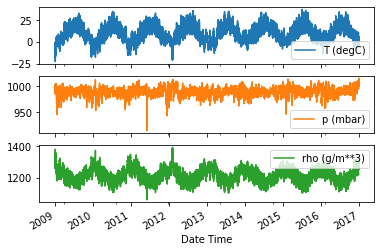

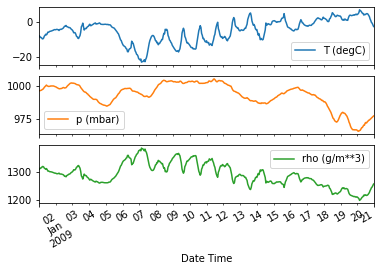

In [6]:
plot_cols = [T, P, RHO]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## inspect and cleanup

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


handle weird *Wind Velocity*

In [8]:
df.loc[df[WV] < 0, :]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
343583,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.0,-9999.0,359.8
343589,990.16,18.71,292.70,12.48,67.07,21.61,14.50,7.12,9.16,14.64,1175.26,-9999.0,-9999.0,359.8
343595,990.15,18.75,292.74,12.27,65.97,21.67,14.29,7.37,9.03,14.44,1175.18,-9999.0,-9999.0,359.8


In [9]:
wv = df[WV]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df[MAXWV]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

df[WV].min()

0.0

# Feature Engineering
## Wind
Angles do not make good model inputs because even though 0 degree and 360 degree are closer, numerically they are not close to each other. It will be easier for the model to interpret if wind direction and wind velocity columns combine to make a wind **vector** from trigonometric equations-

$cos(\theta) = \frac{base}{hypotenuse}$

$sin(\theta) = \frac{perpendicular}{hypotenuse}$

Here we will remove the columns, WD, WV, MAXWV and insert 4 new columns-
1. `Wx`: `x` component of the vector we will get from WV, WD
2. `Wy`: `y` component of the vector we will get from WV, WD
3. `Max Wx`: `x` component of the vector we will get from MAXWV, WD
4. `Max Wy`: `y` component of the vector we will get from WV, WD

In [10]:
WX = 'Wx'
WY = 'Wy'
MAXWX = 'Max Wx'
MAXWY = 'Max Wy'

In [11]:
wv = df.pop(WV)
max_wv = df.pop(MAXWV)
# degree to radian
wd_rad = df.pop(WD) * (np.pi / 180)

df[WX] = wv*np.cos(wd_rad)
df[WY] = wv*np.sin(wd_rad)

df[MAXWX] = max_wv * np.cos(wd_rad)
df[MAXWY] = max_wv * np.sin(wd_rad)

## Time
`Date Time` column numerically is not meaningful- it just increases without keeping any periodical essence. But we know that the weather is seasonal hence `Date Time` column can be an important feature for any model. Converting date time to *sin* and *cos* function will give us periodic data. 

$$
day\_sin = sin(second \times \frac{2 * \pi}{day}) \\
day\_cos = cos(second \times \frac{2 * \pi}{day}) \\
year\_sin = sin(second \times \frac{2 * \pi}{year}) \\
year\_cos = cos(second \times \frac{2 * \pi}{year})
$$

what happens here is that `day_sin, day_cos` represents the second from a day's perspective. same with `year_sin, year_cos`- represents the second from an year's perspective. To simply put, we get **Point in Day** and **Point in Year** from this 4 features.

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [13]:
# new columns
DAYSIN = 'day sin'
DAYCOS = 'day cos'
YEARSIN = 'year sin'
YEARCOS = 'year cos'

In [14]:
day = 24 * 60 * 60
year = (365.2425) * day

df[DAYSIN] = np.sin(timestamp_s * (2 * np.pi / day))
df[DAYCOS] = np.cos(timestamp_s * (2 * np.pi / day))

df[YEARSIN] = np.sin(timestamp_s * (2 * np.pi / year))
df[YEARCOS] = np.cos(timestamp_s * (2 * np.pi / year))

Since from the beginning we sliced the dataset to use only hourly values, these timestamps are of those hours. So is their sin, cos outputs. This means that, for *day sin* and *day cos* will finish a period in 24 samples, while *year sin* and *year cos* will have a period of (24 * 365.2425)

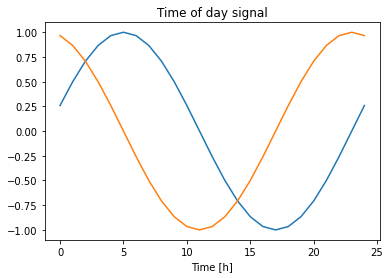

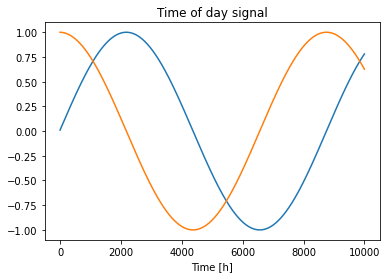

In [15]:
plt.plot(np.array(df[DAYSIN])[:25])
plt.plot(np.array(df[DAYCOS])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

plt.plot(np.array(df[YEARSIN])[:10000])
plt.plot(np.array(df[YEARCOS])[:10000])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

# Preprocess
## Split data
(.7, .2, .1) split for training (learn model params), validation (learn hyperparameters), and test (view generalized error) sets. split without shuffling and resons for doing so,
- make consecutive windows possible
- it makes sense for a time-series model to predict samples that came after training samples

In [16]:
col_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

num_features = df.shape[1]

##  Normalize
subtract the mean and divide by standard deviation. this gives us how many SD away each value is. This way values may change but the relation between samples does not.

the mean and SD should only be calculated from training data, because model should not have access to validation and test sets as any model can only learn from training sets

the model should not also have access to future values- as it happens when we calculate mean on entire training sets and shift each value with it. Because in practice, it is not possible to manipulate todays value using future values that we will not have. But that would make the situation complex and let's just use simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

> Note on `pd.melt` that we will use next
> unpivot a dataframe from wide to long format

In [18]:
wide_df = pd.DataFrame(np.random.rand(3,4), columns=["A", "B","C","D"])
print("a normal dataframe")
display(wide_df)

# take A to be identifier variable, B C to be values of A but in different timesteps
long_df = wide_df.melt(id_vars=('A'), value_vars=("B", "C"))
print("column B, C melted on A")
display(long_df)
# considers all column to be values in different timesteps
long_df = wide_df.melt()
print("all columns melted on index")
display(long_df)

a normal dataframe


,A,B,C,D
0,0.938411,0.118413,0.132023,0.543779
1,0.031110,0.757294,0.428145,0.225100
2,0.959325,0.162840,0.783692,0.163259


column B, C melted on A


,A,variable,value
0,0.938411,B,0.118413
1,0.031110,B,0.757294
2,0.959325,B,0.162840
3,0.938411,C,0.132023
4,0.031110,C,0.428145
5,0.959325,C,0.783692


all columns melted on index


,variable,value
0,A,0.938411
1,A,0.031110
2,A,0.959325
3,B,0.118413
4,B,0.757294
5,B,0.162840
6,C,0.132023
7,C,0.428145
8,C,0.783692
9,D,0.543779


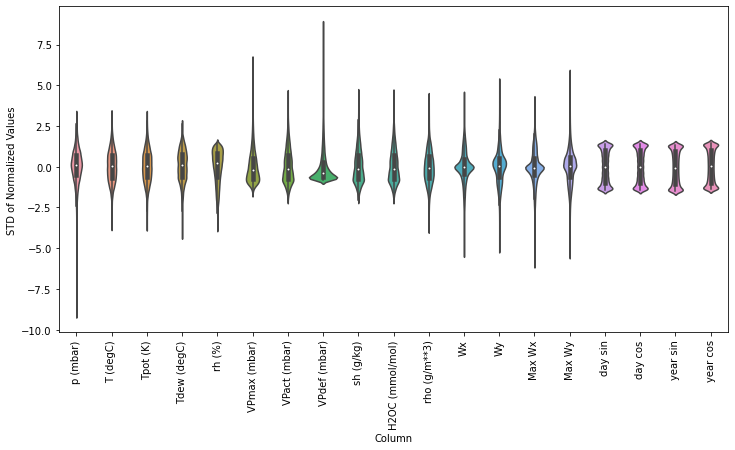

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_ylabel("STD of Normalized Values")
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them (difference between start of input timesteps and start of label timesteps)
- Which features are used as inputs, labels, or both.


With this type of problem, there can be 
- single-feature-output (each output is a scalar), and multi-feature-output (each output is a vector) predictions
- single-time-step, and mulit-time-step predictions

## Defining `Dataset` Class 
- data split for train, val, test will be outside the `dataset` class (which we already did a couple of cells above)
- each of train, val, test will have different object of the same class
- class will have an example batch
- class will return inputs and labels separately
- class will have a plot method that will plot the example sample
- each object will have shape `(batches, timesteps, features)` for input and `(batches, timesteps, labels)` for output
- windowing will happen in `_make_window` and feature, target split will happen in `_split`
- the whole process first makes all the windows, then splits them into features and targets

In [20]:
a = torch.tensor([1,2,3,4])
print("before a.shape:", a.shape)
torch.unsqueeze(a, 1).shape, torch.unsqueeze(a, 1)

before a.shape: torch.Size([4])


(torch.Size([4, 1]), tensor([[1],
         [2],
         [3],
         [4]]))

In [64]:
class TimeSeriesDataset(Dataset):
    """a timeseries dataset with window maker (batch, time, feature)"""
    def __init__(self, df, input_width, label_width, shift=1, step=1, label_cols=None, portion="train"):
        """
        Logical Process for this dataset-
        1. split the 2D data into 3D windowed data
        2. before accessing each window, split them into 
        
        Attributes
        ----------
        df: Dataframe
        label_cols: Iterable of str [Optional]
            contains the column names to use as labels
            
        label_cols_indices: dict [Optional]
            keys are `label_cols` items, values are `0...len(label_cols)-1`
            
        col_indices: dict
            keys are `df` columns, values are `0...len(df.columns)-1`
            
        total_window_size: int
            number of timesteps a single window will take
            
        shift: int
            defines how many timesteps each label will be away from its inputs
            
        step: int
            defines how many timesteps each window will be away from starting of the previous window
        """
        # store raw data in pandas' dataframe
        self.df = df
        
        # work out the label column indices
        self.label_cols = label_cols
        if self.label_cols:
            self.label_cols_indices = {name:i for i, name in enumerate(self.label_cols)}
        
        self.col_indices = {name:i for i, name in enumerate(df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.step = step
        
        # for a specific window, input samples
        # and label samples will be taken from
        # this window
        self.total_window_size = input_width + shift
        
        # will slice each window with these
        self.input_slice = slice(0, input_width)
        self.label_slice = slice(self.total_window_size - label_width, None)
        
        # only for example 
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
        # actual data which will be used in model
        self.data = self._window_generator(data=df.values,
                                          sequence_length=self.total_window_size,
                                          sequence_stride=self.step)
        
        # to torch.Tensor
        _tmp = [self._split_within_window(sample) for sample in self.data]
        
        self.X = torch.stack([
            torch.tensor(it[0],dtype=torch.double).to(DEVICE) for it in _tmp
        ], dim=0)
        
        self.Y = torch.stack([
            torch.tensor(it[1], dtype=torch.double).to(DEVICE) for it in _tmp
        ], dim=0)
        
        
        # example windows (first three)
        self.example = [(torch.unsqueeze(self.X[i].detach(), 0), 
                         torch.unsqueeze(self.Y[i].detach(), 0)) for i in range(3)]
            
        
    def _window_generator(self, data, sequence_length, sequence_stride=1):
        """
        this is a stripped down version of https://github.com/keras-team/keras/blob/master/keras/preprocessing/timeseries.py
        
        Parameters
        ----------
        data: ndarray.
            containing consecutive data points (timesteps). axis 0 is expected to be the time dimension.
            
        sequence_length: int
            length of the output sequences (number of timesteps in a single window)
            
        sequence_stride: int
            period between successive output sequences. For stride `s`, output samples 
            would start at index `data[i]`, `data[i+s]`, `data[i + 2 * s]`, etc
            
        Returns
        -------
        sequences: ndarray
            this is window collections where each window has shape (timesteps, features)
        """
        if sequence_length <= 0:
            raise ValueError(f"validation failed for `sequence_length` {sequence_length}. Each window must contain at least 1 sample.")
        if sequence_stride <= 0:
            raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
        if sequence_stride >= len(data):
            raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')
        # (number of windows, timesteps in each window, features)
        output_shape = (int(np.ceil((data.shape[0]-sequence_length) / sequence_stride)),
                        sequence_length,
                        data.shape[1])
        
        # np.stride are distance between consecutive items in memory
        strides = (data.strides[0] * sequence_stride, ) + data.strides
        to_return = as_strided(data, output_shape, strides, writeable=False).copy()
        
        # make writeable
        to_return.flags["WRITEABLE"] = True
        return to_return
    
    
    
    def _split_within_window(self, sample):
        """
        splits a winodw into inputs and labels
        
        
        """
        inputs = sample[self.input_slice, :]
        labels = sample[self.label_slice, :]
        
        if self.label_cols is not None:
            labels = np.stack(
                [labels[:, self.col_indices[name]] for name in self.label_cols],
                axis=-1)

        return inputs, labels
    
    
    def plot(self, model=None, label_col_no=0, max_subplots=3):
        """
        plot each examples timesteps. if model is provided, plot the predictions too.

        Parameters
        ----------
        model: nn.Module
        label_col_no: int
            determines which column from output cols to plot 
            and determines respective input column from df.columns to plot

        max_subplots: int
            determines how many subplots should there be.
        """
        plt.figure(figsize=(12, 8))
        print(model)

        # split inputs, labels
        inputs = [it[0] for it in self.example]
        labels = [it[1] for it in self.example]

        # find which column from df.columns will be plotted
        try:
            print(self.label_cols_indices)
            # inputs and labels do not have same features
            input_feature_idx = self.col_indices[self.label_cols[label_col_no]]
        except AttributeError:
            # both inputs and labels contain all features
            input_feature_idx = label_col_no


        # number of inputs vs max_subplots
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)

            # y-axis title 
            plt.ylabel(f'{self.label_cols[label_col_no]} (normalized)')

            # timestep vs inputs
            plt.plot(self.input_indices, torch.flatten(inputs[n][:, :, input_feature_idx]),
                     label='inputs', marker='.', zorder=-10)

            # plot the timesteps vs outputs
            plt.scatter(self.label_indices, torch.flatten(labels[n][:, :, label_col_no]),
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            # plot prediction when model is provided
            if model:
                model.eval()
                # nth example
                predictions = model(inputs[n])
                predictions = predictions.detach()

                # plot the timestep vs predicted output
                plt.scatter(self.label_indices, torch.flatten(predictions[:, :, label_col_no]),
                          marker='X', edgecolors='k', label='predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        # must return 3D
        inputs =self.X[idx]
        labels = self.Y[idx]
        
        # set specific shape (window, time, feature)
#         inputs = torch.reshape(inputs, (-1, self.input_width, inputs.shape[-1]))
#         labels = torch.reshape(labels, (-1, self.label_width, labels.shape[-1]))
        
        return inputs, labels
        
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_cols}'])

In [22]:
tsd = TimeSeriesDataset(df=train_df,
                       input_width=5,
                       label_width=2,
                       shift=2,
                        step=2,
                       label_cols=[T, RHO])
print(tsd)

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [5 6]
Label column name(s): ['T (degC)', 'rho (g/m**3)']


In [23]:
tsd.input_indices, tsd.example[0][0].shape, tsd.example[0][0][:, :, 0].shape

(array([0, 1, 2, 3, 4]), torch.Size([1, 5, 19]), torch.Size([1, 5]))

None


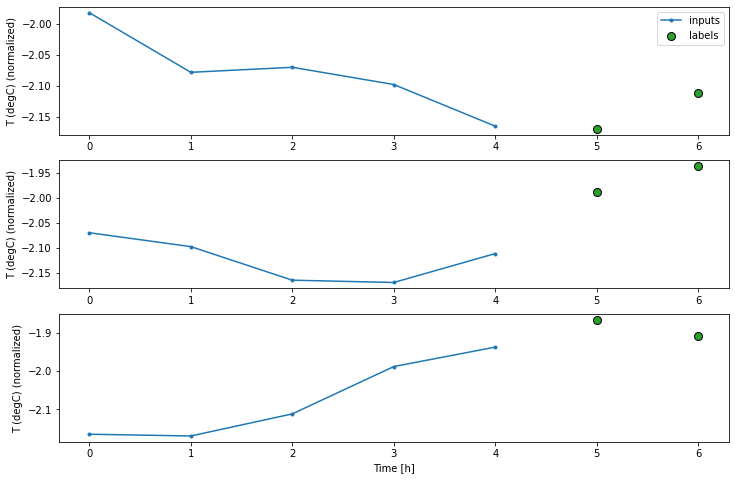

In [24]:
tsd.plot()

# Training Utility

In [25]:
class History:
    def __init__(self, model):
        self.model_info = str(model)
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_loss = []
        self.val_loss = []
        
    def plot(self, figsize=(10,5), xlabel="Epoch", ylabel="loss"):
        fig, ax = plt.subplots(figsize=figsize)
        if len(self.train_loss) > 0:
            ax.plot(range(len(self.train_loss)), self.train_loss, label='train_loss')
            
        if len(self.val_loss) > 0:
            ax.plot(range(len(self.val_loss)), self.val_loss, label='val_loss')
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        
        plt.show()

In [26]:
# settings
val_performance = {}
performance = {}
lr = 0.001
MAX_EPOCH = 20

In [27]:
# utility methods for models
def get_train_test_val(input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T]):
    train_ds = TimeSeriesDataset(df=train_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    
    test_ds = TimeSeriesDataset(df=test_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    val_ds = TimeSeriesDataset(df=val_df,
                        input_width=input_width,
                       label_width=label_width,
                       shift=shift,
                        step=step,
                       label_cols=[T])
    
    
    return train_ds, test_ds, val_ds


def get_data(train_ds, valid_ds, bs=32, collate_fn=None):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, drop_last=True),
        DataLoader(valid_ds, batch_size=bs * 2, collate_fn=collate_fn, drop_last=True),
    )

def collate_fn_custom(data):
    """
       data: a list.
            items of the list are the same format as what `Dataset` class's `__getitem__` returns
    """
    # put all x in (batch, time, feature),  y in (batch, time, label)
    inputs = torch.stack([d[0][0] for d in data], dim=0)
    labels = torch.stack([d[1][0] for d in data], dim=0)
    return inputs, labels
    

def custom_mse(predicted, target):
    _loss = torch.mean((predicted - target)**2)
    return _loss

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, verbose=False):
    history = History(model)
    
    for epoch in range(epochs):
        print(f"[Epoch {epoch}/{epochs}]\n", "-"*20)
        
        train_losses = []
        model.train()
        
        for batch, data in enumerate(train_dl):
            xb, yb = data
            
            # gradients on each variable accumulate, so reset them to 0
            opt.zero_grad()
            outputs = model(xb)
            loss = loss_func(outputs, yb)
            loss.backward()
            opt.step()
            
            if batch%100==0:
                train_losses.append(loss.item())
                if verbose:
                    print(f"batch {batch}/{len(train_dl)} - training loss {loss}")
        
        # validate after each epoch
        val_losses = validate(model, loss_func, valid_dl)
        avg_val_loss = np.mean(val_losses)
        avg_train_loss = np.mean(train_losses)
        print(f"\n mean training loss {avg_train_loss}\n\r mean validation loss {avg_val_loss}")
        
        history.train_loss.append(avg_train_loss)
        history.val_loss.append(avg_val_loss)
        
    return history
        

def validate(model, loss_func, valid_dl):
    losses = []
    model.eval()
    for batch, data in enumerate(valid_dl):
        xb, yb = data

        # gradients on each variable accumulate, so reset them to 0
        outputs = model(xb)
        loss = loss_func(outputs, yb)
        
        if batch % 100==0:
            losses.append(loss.item())
    return losses

# Single Step Models
predicts single timestep

In [28]:
single_step_train = TimeSeriesDataset(df=train_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])

single_step_val = TimeSeriesDataset(df=val_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])
single_step_test = TimeSeriesDataset(df=test_df,
                       input_width=1,
                       label_width=1,
                       shift=1,
                        step=1,
                       label_cols=[T])
single_step_val

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [29]:
single_step_train.example[0][0].shape,single_step_train.example[0][1].shape,

(torch.Size([1, 1, 19]), torch.Size([1, 1, 1]))

## Baseline Model
predicts the current always

In [30]:
class Baseline(nn.Module):
    """returns the same data"""
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def forward(self, xb):
        if self.label_index is None:
            return xb
        else:
            return xb[:, self.label_index]

In [31]:
baseline_model = Baseline(label_index=[single_step_train.col_indices[
    single_step_train.label_cols[0]
]])
# opt = torch.optim.SGD(baseline_model.parameters(), lr=lr)
opt = None
loss_fn = nn.MSELoss()
train_dl, valid_dl = get_data(single_step_train, single_step_val, bs=16, collate_fn=collate_fn_custom)

# epochs, model, loss_func, opt, train_dl, valid_dl
# fit(1, baseline_model, loss_fn, opt, train_dl)
hist = validate(baseline_model, loss_fn, valid_dl)

In [32]:
wide_step_train, wide_step_test, wide_step_val = get_train_test_val(
                        input_width=24,
                       label_width=24,
                       shift=1,
                        step=1,
                       label_cols=[T])
wide_step_train

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

None


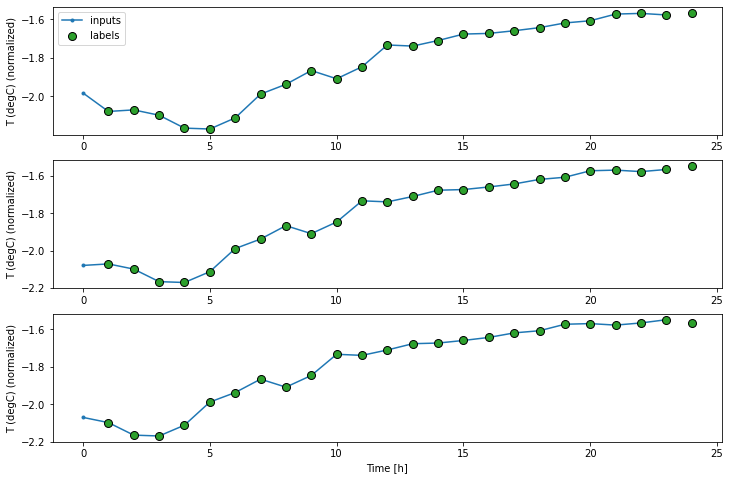

In [33]:
wide_step_train.plot()

In [34]:
train_dl, valid_dl = get_data(wide_step_train, wide_step_val, bs=16, collate_fn=collate_fn_custom)

# epochs, model, loss_func, opt, train_dl, valid_dl
# fit(1, baseline_model, loss, opt, train_dl, valid_dl)
_ = validate(baseline_model, loss_fn, valid_dl)

## Linear 

In [35]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # in 19 feats, out 1 label
        self.linear = nn.Linear(19, 1).double()
        
    def forward(self, xb):
        return self.linear(xb)

In [36]:
linear_model = LinearModel()
linear_model.to(DEVICE)
opt = torch.optim.Adam(linear_model.parameters(), lr=lr)
train_dl, valid_dl = get_data(single_step_train, single_step_val, bs=32)

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(MAX_EPOCH, linear_model, loss_fn, opt, train_dl, valid_dl, verbose=False)

[Epoch 0/20]
 --------------------

 mean training loss 0.5159292276799479
 mean validation loss 0.03701939139331165
[Epoch 1/20]
 --------------------

 mean training loss 0.012029017439127813
 mean validation loss 0.026457615688698977
[Epoch 2/20]
 --------------------

 mean training loss 0.009220818134759601
 mean validation loss 0.01598025753037433
[Epoch 3/20]
 --------------------

 mean training loss 0.007402601249374257
 mean validation loss 0.01109586595439486
[Epoch 4/20]
 --------------------

 mean training loss 0.006790635992730117
 mean validation loss 0.009568198596674092
[Epoch 5/20]
 --------------------

 mean training loss 0.006495553228378565
 mean validation loss 0.009097131478138685
[Epoch 6/20]
 --------------------

 mean training loss 0.006380998123666296
 mean validation loss 0.008991925773132662
[Epoch 7/20]
 --------------------

 mean training loss 0.006353621743998496
 mean validation loss 0.008964919697991647
[Epoch 8/20]
 --------------------

 mean tra

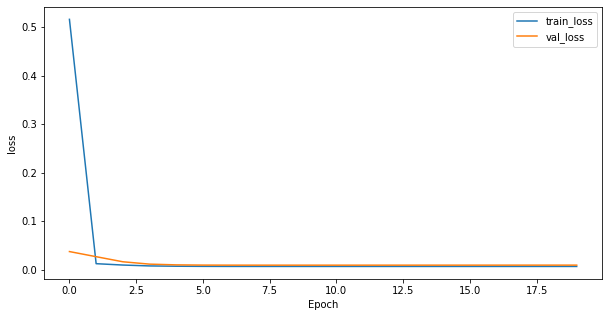

In [37]:
history.plot()

In [38]:
linear_model = LinearModel()
linear_model.to(DEVICE)
opt = torch.optim.Adam(linear_model.parameters(), lr=lr)
train_dl, valid_dl = get_data(wide_step_train, wide_step_val, bs=32)

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(MAX_EPOCH, linear_model, loss_fn, opt, train_dl, valid_dl)

[Epoch 0/20]
 --------------------

 mean training loss 0.5194619968120552
 mean validation loss 0.0405625155248196
[Epoch 1/20]
 --------------------

 mean training loss 0.01232353562831172
 mean validation loss 0.030778344702949295
[Epoch 2/20]
 --------------------

 mean training loss 0.009756934936389771
 mean validation loss 0.01807848413829283
[Epoch 3/20]
 --------------------

 mean training loss 0.007533766204165486
 mean validation loss 0.01210487378545153
[Epoch 4/20]
 --------------------

 mean training loss 0.006772962290364188
 mean validation loss 0.010281919432824404
[Epoch 5/20]
 --------------------

 mean training loss 0.006491863875911896
 mean validation loss 0.0097277825838276
[Epoch 6/20]
 --------------------

 mean training loss 0.00640495200848697
 mean validation loss 0.009653111110374264
[Epoch 7/20]
 --------------------

 mean training loss 0.006400471229721337
 mean validation loss 0.009653358357047928
[Epoch 8/20]
 --------------------

 mean training

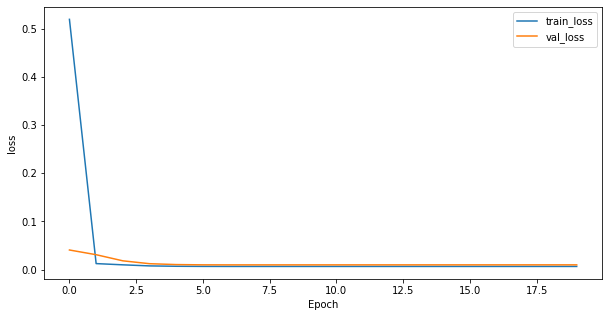

In [39]:
history.plot()

## Dense
stacking several layers of `Linear` layer with activation

In [40]:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(19, 64).double()
        self.linear2 = nn.Linear(64,64).double()
        self.linear3 = nn.Linear(64,1).double()
        
        self.linear = nn.Linear(19,1).double()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x

[Epoch 0/10]
 --------------------

 mean training loss 0.32519695152872014
 mean validation loss 0.011957121032143362
[Epoch 1/10]
 --------------------

 mean training loss 0.00900341854439183
 mean validation loss 0.012478961289951658
[Epoch 2/10]
 --------------------

 mean training loss 0.009396959783141166
 mean validation loss 0.010453778067941285
[Epoch 3/10]
 --------------------

 mean training loss 0.007873566240798229
 mean validation loss 0.010226198912454233
[Epoch 4/10]
 --------------------

 mean training loss 0.0075290276240833716
 mean validation loss 0.009998626531457527
[Epoch 5/10]
 --------------------

 mean training loss 0.007374904349890262
 mean validation loss 0.008233782435005072
[Epoch 6/10]
 --------------------

 mean training loss 0.007441215232006715
 mean validation loss 0.008098906732269151
[Epoch 7/10]
 --------------------

 mean training loss 0.007176327203410089
 mean validation loss 0.007565435200200728
[Epoch 8/10]
 --------------------

 mean

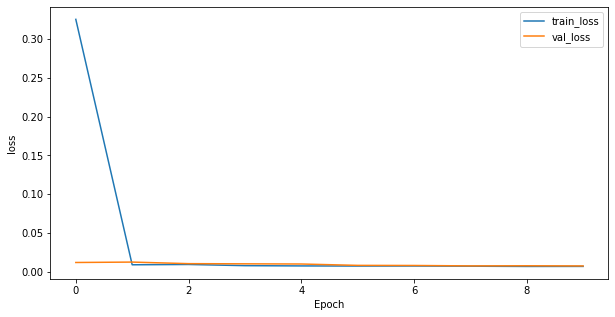

In [41]:
dense_model = DenseModel()
dense_model.to(DEVICE)
opt = torch.optim.Adam(dense_model.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=wide_step_train, valid_ds=wide_step_val, bs=64)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, dense_model, loss_fn, opt, train_dl, valid_dl)
history.plot()

DenseModel(
  (linear1): Linear(in_features=19, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (linear): Linear(in_features=19, out_features=1, bias=True)
  (relu): ReLU()
)


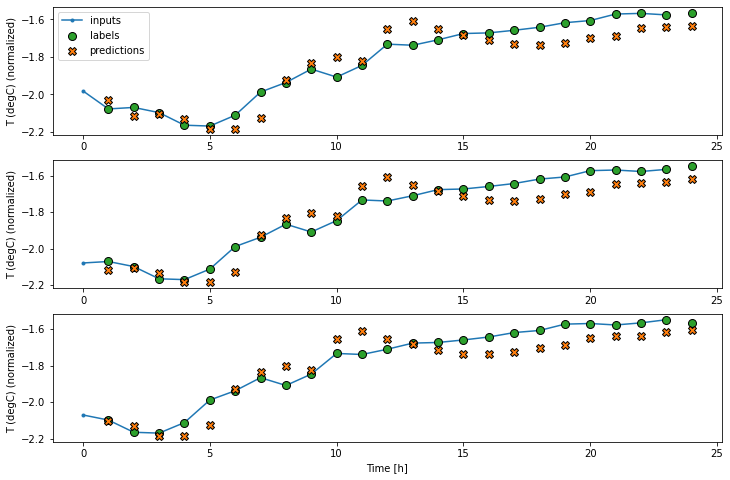

In [42]:
wide_step_train.plot(dense_model)

## Multi-step Dense

![image.png](attachment:8953f563-0695-4738-88e7-395e7816ad82.png)![image.png](attachment:195a5f8d-7ddb-4078-9f4c-5f276d46b30a.png)

In [43]:
CONV_WIDTH = 3
conv_step_train = TimeSeriesDataset(df=train_df,
                                input_width=CONV_WIDTH,
                               label_width=1,
                               shift=1,
                               step=1,
                               label_cols=[T])

conv_step_val = TimeSeriesDataset(df=val_df,
                                input_width=CONV_WIDTH,
                               label_width=1,
                               shift=1,
                               step=1,
                               label_cols=[T])


conv_step_train

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

None


(torch.Size([1, 3, 19]), torch.Size([1, 1, 1]))

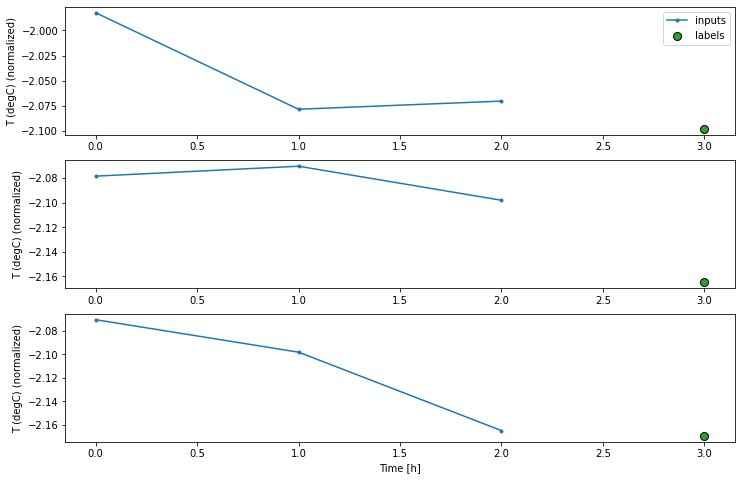

In [44]:
conv_step_train.plot()
conv_step_train.example[0][0].shape, conv_step_train.example[0][1].shape

In [45]:
class MultiStepDense(nn.Module):
    def __init__(self, n_features=19, n_timesteps=3):
        super().__init__()
        self.relu = nn.ReLU()
        # shape: (time, features) => (time * features, )
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1).double()
        
        self.linear1 = nn.Linear(n_features * n_timesteps, 32).double()
        self.linear2 = nn.Linear(32, 32).double()
        self.linear3 = nn.Linear(32, 1).double()
        
        # shape: (label, ) => (1, label)
        self.unflatten = nn.Unflatten(1, (1,1))
        
    def forward(self, x):
#         print(x.shape)
        x = self.flatten(x)
#         print(x.shape)
        x = self.linear1(x)
        x = self.relu(x)
#         print(x.shape)
        x = self.linear2(x)
        x = self.relu(x)
#         print(x.shape)
        x = self.linear3(x)
#         print(x.shape)
        x = self.unflatten(x)
#         print(x.shape)
        return x

In [46]:
multi_step_dense = MultiStepDense(n_features=19, n_timesteps=3)
print("input shape: ", conv_step_train.example[0][0].shape)
print("output shape: ", multi_step_dense(conv_step_train.example[0][0]).shape)

input shape:  torch.Size([1, 3, 19])
output shape:  torch.Size([1, 1, 1])


[Epoch 0/10]
 --------------------

 mean training loss 0.17008252396510826
 mean validation loss 0.01898714982698493
[Epoch 1/10]
 --------------------

 mean training loss 0.008762286208673331
 mean validation loss 0.009998123407060147
[Epoch 2/10]
 --------------------

 mean training loss 0.007023711284331753
 mean validation loss 0.008148285924927917
[Epoch 3/10]
 --------------------

 mean training loss 0.0067513433602931485
 mean validation loss 0.008082144209943269
[Epoch 4/10]
 --------------------

 mean training loss 0.005885565161110188
 mean validation loss 0.007871016415464038
[Epoch 5/10]
 --------------------

 mean training loss 0.005892031634006556
 mean validation loss 0.0077510608061958156
[Epoch 6/10]
 --------------------

 mean training loss 0.0056631602495353685
 mean validation loss 0.00795553318151583
[Epoch 7/10]
 --------------------

 mean training loss 0.005364139839433173
 mean validation loss 0.007660501705278047
[Epoch 8/10]
 --------------------

 mea

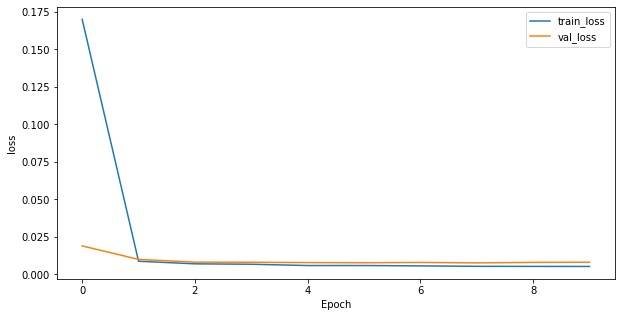

In [47]:
multi_step_dense = MultiStepDense(19, 3)
multi_step_dense.to(DEVICE)
opt = torch.optim.Adam(multi_step_dense.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=conv_step_train, valid_ds=conv_step_val, bs=32)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, multi_step_dense, loss_fn, opt, train_dl, valid_dl)
history.plot()

MultiStepDense(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=57, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 1))
)


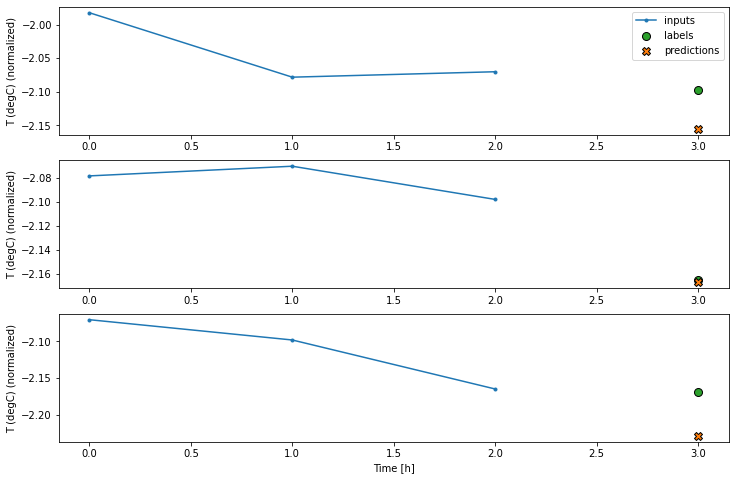

In [48]:
conv_step_train.plot(multi_step_dense)

# Recurrent Neural Networks
if `return_sequences=False` means model will only return output from last timestep, and `return_sequences=True` means model will return output for all timesteps. The later makes any model a multistep model

In [49]:
print('input shape', wide_step_train.example[0][0].shape)
print('output shape', wide_step_train.example[0][1].shape)

input shape torch.Size([1, 24, 19])
output shape torch.Size([1, 24, 1])


In [50]:
class LstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        # (batch, time, featres) => (batch, time, lstm_units)
        self.lstm = nn.LSTM(input_size=19,
                            hidden_size=32).double()
        # (batch, time, lstm_units) => (batch, time, features)
        self.lin = nn.Linear(32, 1).double()
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.lin(x)
        
        return x

[Epoch 0/10]
 --------------------

 mean training loss 0.22995620879697343
 mean validation loss 0.019741969115899104
[Epoch 1/10]
 --------------------

 mean training loss 0.006246761689275335
 mean validation loss 0.011903325782775143
[Epoch 2/10]
 --------------------

 mean training loss 0.005309384201844067
 mean validation loss 0.00970883903048038
[Epoch 3/10]
 --------------------

 mean training loss 0.005288035726071125
 mean validation loss 0.009593406358837537
[Epoch 4/10]
 --------------------

 mean training loss 0.005062894156991421
 mean validation loss 0.009437718670360732
[Epoch 5/10]
 --------------------

 mean training loss 0.00486018179378073
 mean validation loss 0.009556825172357043
[Epoch 6/10]
 --------------------

 mean training loss 0.004787017068639974
 mean validation loss 0.009730720213785628
[Epoch 7/10]
 --------------------

 mean training loss 0.004719475289663587
 mean validation loss 0.00989820679438092
[Epoch 8/10]
 --------------------

 mean tr

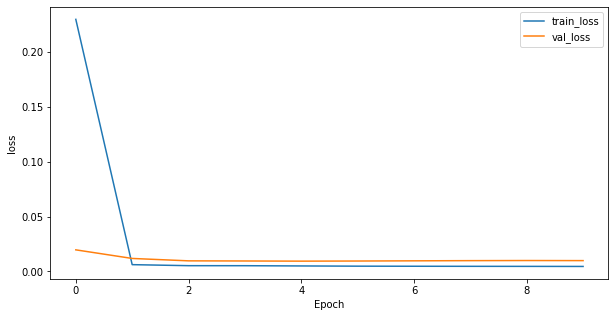

In [51]:
lstm_model = LstmModel()
lstm_model.to(DEVICE)
opt = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
train_dl, valid_dl = get_data(train_ds=wide_step_train, valid_ds=wide_step_val, bs=32)
loss_fn = nn.MSELoss()

# epochs, model, loss_func, opt, train_dl, valid_dl
history = fit(10, lstm_model, loss_fn, opt, train_dl, valid_dl)
history.plot()

LstmModel(
  (lstm): LSTM(19, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


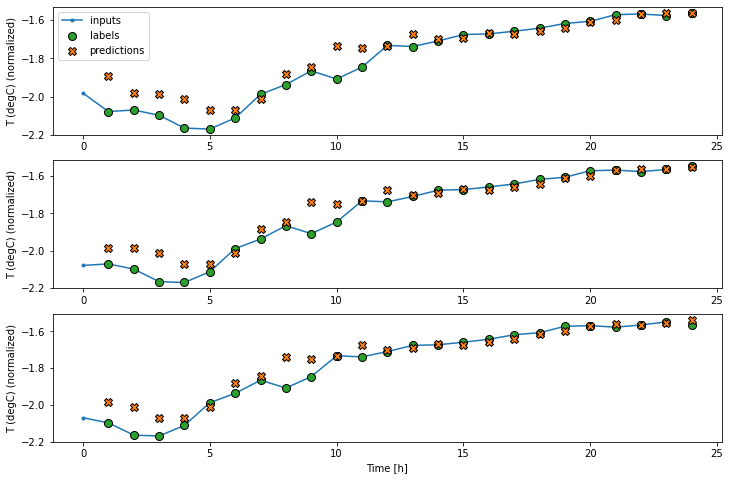

In [52]:
wide_step_train.plot(lstm_model)

# Multi-output Model

In [66]:
wide_window_train = TimeSeriesDataset(df=train_df,
                                input_width=24,
                               label_width=24,
                               shift=1,
                               step=1)

wide_window_val = TimeSeriesDataset(df=val_df,
                                input_width=24,
                               label_width=24,
                               shift=1,
                               step=1)

display(wide_window_train)
print("input shape",  wide_window_train.example[0][0].shape)
print("output shape",  wide_window_train.example[0][1].shape)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): None

input shape torch.Size([1, 24, 19])
output shape torch.Size([1, 24, 19])


## Baseline

In [54]:
baseline_model = Baseline()
opt = None
loss_fn = nn.MSELoss()
train_dl, valid_dl = get_data(wide_window_train, wide_window_val, bs=32, collate_fn=collate_fn_custom)

# epochs, model, loss_func, opt, train_dl, valid_dl
# fit(1, baseline_model, loss_fn, opt, train_dl)
hist = validate(baseline_model, loss_fn, valid_dl)

## Dense

In [56]:
class DenseModelV2(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes=[64,64]):
        super().__init__()
        # layers
        self.linear1 = nn.Linear(in_features, hidden_sizes[0]).double()
        self.linear2 = nn.Linear(hidden_sizes[0], hidden_sizes[1]).double()
        self.linear3 = nn.Linear(hidden_sizes[1], out_features).double()
        
        # non-linear activation layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x

In [58]:
dense_model_v2 = DenseModelV2(19, 19)
dense_model_v2.to(DEVICE)
train_dl, val_dl = get_data(wide_window_train, wide_window_val)
opt = torch.optim.Adam(dense_model_v2.parameters())
loss = nn.MSELoss()

history = fit(10, dense_model_v2, loss, opt, train_dl, val_dl)

[Epoch 0/10]
 --------------------

 mean training loss 0.19782557764145983
 mean validation loss 0.14385137535282305
[Epoch 1/10]
 --------------------

 mean training loss 0.0793517397329559
 mean validation loss 0.1080738649432923
[Epoch 2/10]
 --------------------

 mean training loss 0.07488045585420246
 mean validation loss 0.10446161913170325
[Epoch 3/10]
 --------------------

 mean training loss 0.07317459624698996
 mean validation loss 0.10442607603815278
[Epoch 4/10]
 --------------------

 mean training loss 0.07225367727855664
 mean validation loss 0.10038989844009712
[Epoch 5/10]
 --------------------

 mean training loss 0.07086840880024206
 mean validation loss 0.09558693955072135
[Epoch 6/10]
 --------------------

 mean training loss 0.06956470492644506
 mean validation loss 0.09428154584156075
[Epoch 7/10]
 --------------------

 mean training loss 0.06880409560895609
 mean validation loss 0.09288404807277144
[Epoch 8/10]
 --------------------

 mean training loss 0.

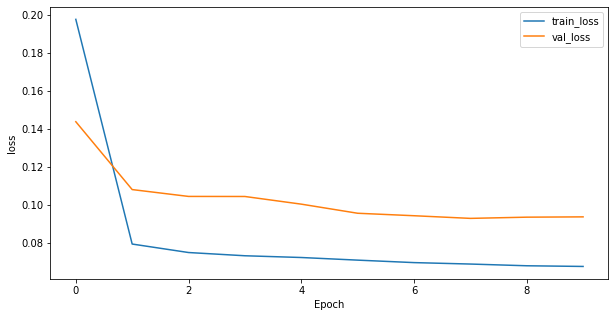

In [59]:
history.plot()

## RNN

In [70]:
class LstmModelV2(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes=[32]):
        super().__init__()
        # (batch, time, featres) => (batch, time, lstm_units)
        self.lstm = nn.LSTM(input_size=in_features,
                            hidden_size=hidden_sizes[0]).double()
        # (batch, time, lstm_units) => (batch, time, features)
        self.lin = nn.Linear(hidden_sizes[0], out_features).double()
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.lin(x)
        
        return x

[Epoch 0/10]
 --------------------

 mean training loss 0.23584527675038325
 mean validation loss 0.11188408463648551
[Epoch 1/10]
 --------------------

 mean training loss 0.07716434860108701
 mean validation loss 0.09228527700617876
[Epoch 2/10]
 --------------------

 mean training loss 0.06964548178100301
 mean validation loss 0.08604663855585193
[Epoch 3/10]
 --------------------

 mean training loss 0.06668239042850989
 mean validation loss 0.08310946159496102
[Epoch 4/10]
 --------------------

 mean training loss 0.06487271243610478
 mean validation loss 0.08165142982469056
[Epoch 5/10]
 --------------------

 mean training loss 0.06384374269087391
 mean validation loss 0.080807118780665
[Epoch 6/10]
 --------------------

 mean training loss 0.06316245407651355
 mean validation loss 0.08033021619846668
[Epoch 7/10]
 --------------------

 mean training loss 0.06264127211759196
 mean validation loss 0.07988471093583649
[Epoch 8/10]
 --------------------

 mean training loss 0.

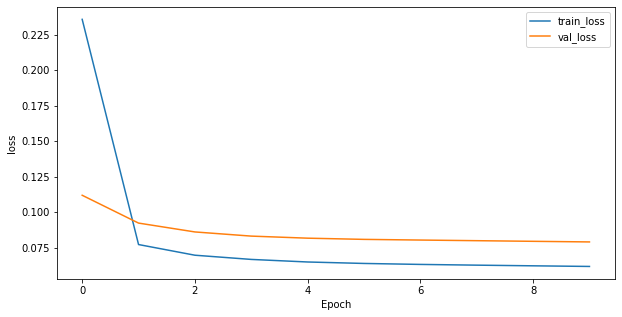

In [71]:
lstm_model_v2 = LstmModelV2(19, 19)
lstm_model_v2.to(DEVICE)
train_dl, val_dl = get_data(wide_window_train, wide_window_val)
opt = torch.optim.Adam(lstm_model_v2.parameters())
loss = nn.MSELoss()

history = fit(10, lstm_model_v2, loss, opt, train_dl, val_dl)
history.plot()